https://arxiv.org/abs/1704.05579  (guide)

Kaggle provides Self-Annotated Reddit Corpus (SARC) [dataset](https://www.kaggle.com/danofer/sarcasm) containing 1.3 million sarcastic comments from Reddit. Redditors commentate on submissions - texts, links, images - and often these comments are sarcastic. However, sarcasm can be ambiguously interpreted, which necessitates the placement of the "/s" tag to indicate sarcasm. Even if you argue a well executed sarcasm doesn't require one, the /s has become a useful marker for sarcasm analysis.

Hypothetically, Reddit users are anonymous making context unavailable for much of sarcasm; therefore, it's more difficult to convey. This is arguably why '/s' is much more common on Reddit than Twitter (0.002% vs 0.927%). 

SARC [contributors](https://arxiv.org/abs/1704.05579 ) have attempted to filter out noisy '/s' comments which are often annotations (e.g "you forgot to add the /s"), false positives (misused /s on non-sarcastic comment), and false negatives (sarcastic comments which are not marked with /s). These are the limitations of sarcasm analysis. 

I'd like to thank Aashita for her [textblob] idea (https://www.kaggle.com/aashita/exploratory-data-analysis-of-comments-on-nyt)

In the data, 1 indicates sarcasm and 0 indicates not-sarcasm. 

**Objective**
We will use logistic regression to detect sarcasm. Visualization from eli5 library to see what kind of features had e how they the most weight. Then we will observe sentiment and subjectivity of comments, to see how they correlate with comment karma (upvotes vs downvotes) and sarcastic comments. 

## Initialize 

In [1]:
# imports
import os
import numpy as np
import pandas as pd
from textblob import TextBlob 

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression 
from sklearn.pipeline import Pipeline 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score, confusion_matrix 

import seaborn as sns 
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt 

%matplotlib inline

## Reading & Modifying CSV File 

The dataset contains a million rows making it diffciult to use outside of kernels. I wanted to shorten it with a few select columns that will still provide me plenty of data to analyze. Below is the code in the comments which creates 'modifiedsarcasm' csv file.  

In [2]:
#train_df = pd.read_csv('train-balanced-sarcasm.csv')
# new_column = ['AskReddit','politics', 'worldnews', 'funny','todayilearned','nba','nfl']

# train_df = train_df.loc[train_df['subreddit'].isin(new_column) ]
# train_df.to_csv('modifiedsarcasm.csv') 
train_df = pd.read_csv('modifiedsarcasm.csv')

In [3]:
train_df.head(3)

,Unnamed: 0,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.


In [4]:
train_df.shape

(191946, 11)

In [5]:
train_df['subreddit'].value_counts() 

AskReddit        65677
politics         39496
worldnews        26377
funny            17939
todayilearned    14161
nfl              14150
nba              14146
Name: subreddit, dtype: int64

## Cleaning Data

In [6]:
train_cf = train_df.copy() 

In [7]:
train_cf.shape

(191946, 11)

In [8]:
train_cf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191946 entries, 0 to 191945
Data columns (total 11 columns):
Unnamed: 0        191946 non-null int64
label             191946 non-null int64
comment           191936 non-null object
author            191946 non-null object
subreddit         191946 non-null object
score             191946 non-null int64
ups               191946 non-null int64
downs             191946 non-null int64
date              191946 non-null object
created_utc       191946 non-null object
parent_comment    191946 non-null object
dtypes: int64(5), object(6)
memory usage: 16.1+ MB


In [9]:
# looks like some entries may be missing. Check. 
train_cf.isna().sum()

Unnamed: 0         0
label              0
comment           10
author             0
subreddit          0
score              0
ups                0
downs              0
date               0
created_utc        0
parent_comment     0
dtype: int64

Based on this, we know 10 rows are missing a comment. Let's just clean this up by dropping them. 

In [10]:
# drop rows where at least one element is missing, based on subset
train_cf.dropna(subset=['comment'], inplace=True)
train_cf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 191936 entries, 0 to 191945
Data columns (total 11 columns):
Unnamed: 0        191936 non-null int64
label             191936 non-null int64
comment           191936 non-null object
author            191936 non-null object
subreddit         191936 non-null object
score             191936 non-null int64
ups               191936 non-null int64
downs             191936 non-null int64
date              191936 non-null object
created_utc       191936 non-null object
parent_comment    191936 non-null object
dtypes: int64(5), object(6)
memory usage: 17.6+ MB


In [11]:
# double check to see if missing values are eliminated
train_cf.isna().sum()

Unnamed: 0        0
label             0
comment           0
author            0
subreddit         0
score             0
ups               0
downs             0
date              0
created_utc       0
parent_comment    0
dtype: int64

In [12]:
# 1 indicates sarcasm, 0 indicates non-sarcasm
train_cf['label'].value_counts()

1    97733
0    94203
Name: label, dtype: int64

In [13]:
train_cf['comment'].shape, train_cf['label'].shape

((191936,), (191936,))

Split data into training and test sets. 

In [14]:
train_texts, valid_texts, y_train, y_valid = \
        train_test_split(train_cf['comment'], train_cf['label'], random_state=17)

train_texts.shape, valid_texts.shape, y_train.shape, y_valid.shape

((143952,), (47984,), (143952,), (47984,))

In [15]:
train_texts.head()

133263       I had cooking classes in middle school though.
17357     Good thing those emails were illegally obtaine...
132756                     Freedom will be FEDEXed shortly.
85054     Perhaps he anonymously donates his money to ch...
35237     The adult version is called a "Brazilian Steak...
Name: comment, dtype: object

I'll build a logistic regression combined with tf-idf (term frequency-inverse document frequency). Hopefully we can predict sarcasm labels based on their respectie Reddict comments. 

## Word Cloud

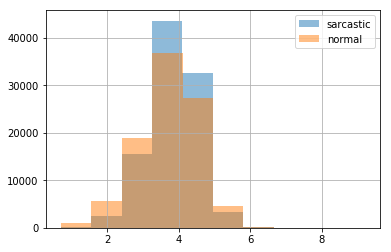

In [16]:
# log1p is log(x+1), allows better view of histogram
train_cf.loc[train_cf['label'] == 1, 'comment'].str.len().apply(np.log1p).hist(label='sarcastic', alpha=.5)
train_cf.loc[train_cf['label'] == 0, 'comment'].str.len().apply(np.log1p).hist(label='normal', alpha=.5)
plt.legend();

In [17]:
from wordcloud import WordCloud, STOPWORDS

In [18]:
wordcloud = WordCloud(background_color='black', stopwords = STOPWORDS, max_words = 200, max_font_size = 100,random_state = 17, width=800, height=400)

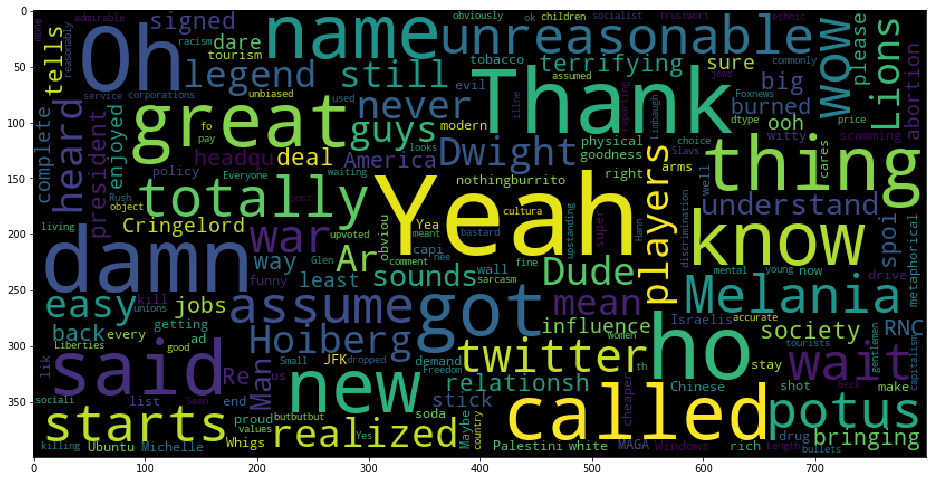

In [19]:
# generate wordcloud for words commonly used in sarcastic comments  
plt.figure(figsize=(16, 12))
wordcloud.generate(str(train_cf.loc[train_cf['label'] == 1, 'comment']))
plt.imshow(wordcloud);

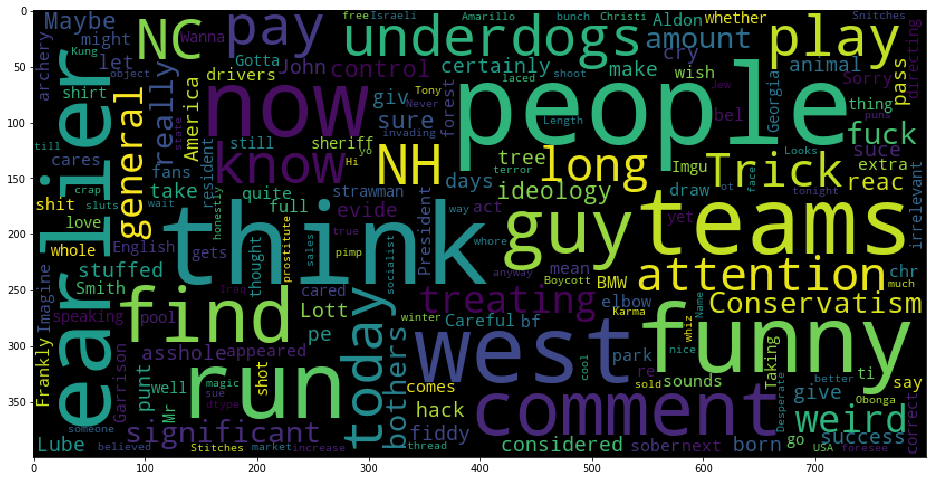

In [20]:
# generate wordcloud for words commonly used in non-sarcastic comments
plt.figure(figsize=(16, 12))
wordcloud.generate(str(train_cf.loc[train_cf['label'] == 0, 'comment']))
plt.imshow(wordcloud);

## Training the Model - TFIDF and Logistic Regression

We want to analyze sarcastic texts. But texts cannot be used in machine learning directly - we must convert them to numbers through tokenization. 

Tfidf stands for term-frequency (summarizes how often a given word appears within a document)  and inverse-document-frequency (downscales logarithmically words that appear frequently across multiple documents). With Tfidf, unlike a frequency table technique, we do not have to worry about stop words ('the', 'a', 'and', etc.) and only pre-process removal of punctuation and lower casing. Google search engines use TF-IDF to rank content. 

Transformer = some class that has tools to fit and transform data

Predictor = some class that has tools to fit and predict methods. 

In [21]:
# build bigrams, put a limit on maximal number of features 
# and minimal word frequency 
# lower and upper boundary of 1 to 2 for n-values 
# only build vocabulary using top 50000 max_features
# ignore terms that have document frequency lower than threshold 2 

tf_idf = TfidfVectorizer(ngram_range=(1, 2), max_features=50000, min_df=2)

# multinomial logistic regression a.k.a softmax classifier 
logit = LogisticRegression(C=1, n_jobs=4, solver='lbfgs', random_state=17, verbose=1)

# sklearn's pipeline
tfidf_logit_pipeline = Pipeline([('tf_idf', tf_idf), 
                                 ('logit', logit)])

For machine learning, we need to perform different transformations (e.g finding features, generating new features, picking out relevant features) of a raw dataset before applying a final estimator. Pipeline combines transformers and predictors all into one neat interface. This means that you only have toall your important methods (fit(), predict(), etc) a single time. 

Each step has to be a transformer except the last, which can be a transformer or a predictor. 

In [22]:
%%time
tfidf_logit_pipeline.fit(train_texts, y_train)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Wall time: 13.9 s


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    6.1s finished


Pipeline(memory=None,
     steps=[('tf_idf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=50000, min_df=2,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=Tru... penalty='l2', random_state=17, solver='lbfgs', tol=0.0001,
          verbose=1, warm_start=False))])

In [23]:
%%time 
valid_pred = tfidf_logit_pipeline.predict(valid_texts)

Wall time: 1.75 s


In [24]:
accuracy_score(y_valid,valid_pred)

0.7216988996332111

## Confusion Matrix

In [25]:
def plot_confusion_matrix(actual, predicted, classes,
                          normalize=False,
                          title='Confusion matrix', figsize=(7,7),
                          cmap=plt.cm.Blues, path_to_save_fig=None):

    
    import itertools
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(actual, predicted).T
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('Predicted label')
    plt.xlabel('True label')

    if path_to_save_fig:
        plt.savefig(path_to_save_fig, dpi=300, bbox_inches='tight')

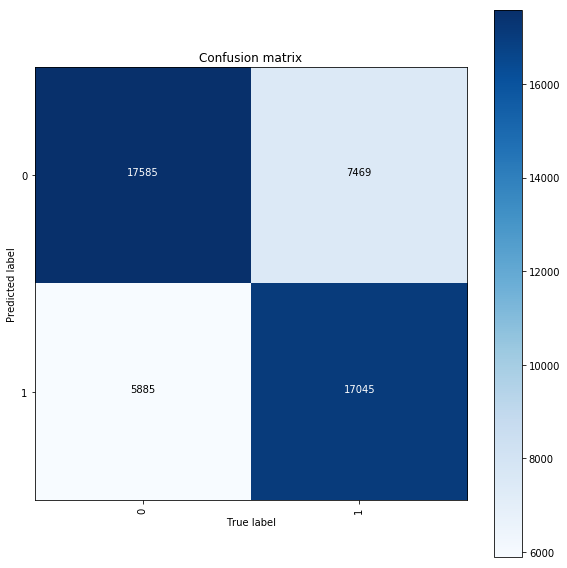

In [26]:
plot_confusion_matrix(y_valid, valid_pred, 
                      tfidf_logit_pipeline.named_steps['logit'].classes_, figsize=(8, 8))

The confusion matrix describes the performance of a classification model. As this is supervised learning, we already know the true values (e.g whether a comment is sarcastic). 

https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/

We can see that 96,000 samples were predicted 0 and also happened to be a true 0, while 86,000 samples were predicted 1 and also happened to be a true 1. 

## Eli5 - demonstrating sarcastic weights 

In order to get a more initimate understanding of the model and how it interprets sarcasm, we can use the eli5 library. 

In [27]:
import eli5
eli5.show_weights(estimator=tfidf_logit_pipeline.named_steps['logit'],
                  vec=tfidf_logit_pipeline.named_steps['tf_idf'])

Weight?,Feature
+7.103,yeah
+6.868,clearly
+6.604,obviously
+6.293,totally
+6.069,yes because
+5.999,because
+4.233,yea
+4.209,forgot
+4.159,good thing
+4.134,sure


Let's analyze a comment that's not sarcastic. I'll pick one from the nba subreddit and which was marked as 'sarcastic'. 

In [28]:
train_cf.loc[(train_cf['subreddit']=='nba')&(train_cf['label']==1)]

,Unnamed: 0,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
20,74,1,"Hoiberg said ""great players"", not Dwight",deezee72,nba,29,-1,-1,2016-11,2016-11-01 03:45:25,except the 2012 lakers
63,255,1,I mean if you guys still don't understand what...,fear865,nba,140,-1,-1,2016-11,2016-11-03 15:35:05,Yes how dare we hurt him so badly
470,2180,1,Yeah not as cool though,Mdgt_Pope,nba,2,-1,-1,2016-11,2016-11-05 16:26:58,He's also the guy that took a picture of a shu...
520,2382,1,Cuz thats gay duh,agomezian,nba,5,-1,-1,2016-11,2016-11-06 07:49:25,why is it weird for a dude to call another dud...
521,2385,1,Something something Dwight has 12 kids,objectiveye,nba,1,-1,-1,2016-11,2016-11-06 08:29:08,"Dwight always starts off not shit, then it goe..."
597,2735,1,It's too bad Kobe didn't stick around for anot...,sayitlikeyoumemeit,nba,-1,-1,-1,2016-11,2016-11-07 18:34:41,lakers are the funnest team to root for and wa...
747,3453,1,I'm very happy as well.,threekingmodest101,nba,5,-1,-1,2016-11,2016-11-10 16:53:26,we are also enjoying the Knicks defense this s...
1013,4808,1,You're worse than Stephen A Smith man.,clutch-city2k15,nba,1,-1,-1,2016-11,2016-11-19 10:00:47,Unpopular opinion: Basketball is fun
1189,5724,1,Why are we pretending 402 made threes on 11 at...,MiopTop,nba,9,-1,-1,2016-11,2016-11-28 10:26:47,Curry because he actually did his
1209,5916,1,Wonder how many rebounds he stole from his big...,CarlDrogo54321,nba,3,-1,-1,2016-11,2016-11-30 05:39:37,Chris Paul has his first Triple Double of the ...


I'll take the 4th row comment and look at its sarcasm value. 

In [29]:
eli5.show_prediction(estimator=tfidf_logit_pipeline.named_steps['logit'],vec=tfidf_logit_pipeline.named_steps['tf_idf'], doc='Yeah not as cool though')

If we modified the comment into something that wouldn't normally be perceived as sarcasm, like the phrase 'Yeah that was not funny /s' which sounds serious and direct, we should get a low probability and prediction score. 

In [30]:
eli5.show_prediction(estimator=tfidf_logit_pipeline.named_steps['logit'],vec=tfidf_logit_pipeline.named_steps['tf_idf'], doc='Yeah that was not funny though')

We get a very low score like we expected. 

## Textblob Analysis of Comments

Textblob is a library designed for emotional analysis of text. For example, the **sentiment** property from the Textblob library has a 'polarity' and 'subjectivity' tuple score. 

Polarity is between -1 and 1, where -1 represents very negative text and 1 represents very positive text. Subjectivity is between 0 and 1, where 0 represents very objective and 1 represents very subjective. 

Ideally what we should expect is reddit comments with many downvotes should in general be very subjective in sentiment. 

In [31]:
# reviewing what dataframe looks like 
train_df.head()

,Unnamed: 0,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,5,0,"I don't pay attention to her, but as long as s...",only7inches,AskReddit,0,0,0,2016-09,2016-09-02 10:35:08,do you find ariana grande sexy ?
4,6,0,Trick or treating in general is just weird...,only7inches,AskReddit,1,-1,-1,2016-10,2016-10-23 21:43:03,What's your weird or unsettling Trick or Treat...


In [32]:
nba_df = train_df.loc[train_df['subreddit']=='nba']
nba_df.head()


,Unnamed: 0,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
1,1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
20,74,1,"Hoiberg said ""great players"", not Dwight",deezee72,nba,29,-1,-1,2016-11,2016-11-01 03:45:25,except the 2012 lakers
52,219,0,You can't expect the Knicks to make the playof...,socoamaretto,nba,-1,-1,-1,2016-10,2016-10-25 21:26:12,Calling a top 5 seed? I asked if we could EXPE...
58,240,0,damn bro injuries sux,Dogdip,nba,1,-1,-1,2016-12,2016-12-30 02:29:26,Sprained wrist from a fall happened almost two...
63,255,1,I mean if you guys still don't understand what...,fear865,nba,140,-1,-1,2016-11,2016-11-03 15:35:05,Yes how dare we hurt him so badly


In [33]:
# We write the two functions that are used often:
# def print_largest_values(s, n=5):
#     s = sorted(s.unique())
#     for v in s[-1:-(n+1):-1]:
#         print(v)
#     print()
    
# def print_smallest_values(s, n=5):
#     s = sorted(s.unique())
#     for v in s[:n]:
#         print(v)
#     print()

We can make columns for text polarity and subjectivity. I want to see how these correlate with the karma score. 

In [34]:
# making subjectivity and polarity columns 
import warnings 
warnings.filterwarnings('ignore')

nba_df['polarity'] = nba_df.comment.map(lambda text:TextBlob(text).sentiment.polarity)

nba_df['subjectivity']=nba_df.comment.map(lambda text:TextBlob(text).sentiment.subjectivity)

Let's try looking at positive sentiment polarity comments and their score. 

In [35]:
print("5 random comments with highest positive sentiment polarity: \n")
pol_sample= nba_df.loc[nba_df.sentiment==1, ['comment','subjectivity','score']].head(5)

print(pol_sample)

# to see full comments 
for i in pol_sample['comment'].head(5):
    print() # skip line 
    print(i) 


5 random comments with highest positive sentiment polarity: 



AttributeError: 'DataFrame' object has no attribute 'sentiment'

Now we'll try negative sentiment polarity comments and their score. 

In [ ]:
print("5 random comments with lowest negative sentiment polarity: \n")
pol_sample= nba_df.loc[nba_df.sentiment==-1, ['comment','subjectivity','score']].head(5)

print(pol_sample)

# to see full comments 
for i in pol_sample['comment'].head(5):
    print() # skip line 
    print(i) 

# nba_df.loc[nba_df.sentiment==1, ['comment']].

I suspect the subjectivity and polarity ratings are not designed to capture nuisances, instead opting for more intense emotional measurements than the average comment. 

In [ ]:
mpl.rcParams['figure.figsize'] = (12, 8)
mpl.rcParams['axes.titlesize'] = 'xx-large'
mpl.rcParams['axes.labelsize'] = 'xx-large'
fig, ax = plt.subplots()


sns.distplot(nba_df['polarity'], label='polarity')
sns.distplot(nba_df.subjectivity, label='subjectivity')

plt.legend()
ax.set(xlabel='Sentiment Levels', ylabel='Distribution Density', title='Distribution of sentiment')

Most r/nba comments have polarities and subjectivity closer to 0. However, subjetivity tends to be higher in the upper quantile. 

In [ ]:
sns.set(rc={'axes.labelsize':25})
grid = sns.jointplot('polarity', 'score', data=nba_df)
grid.fig.set_figwidth(18)
grid.fig.set_figheight(18)
grid.fig.subplots_adjust(top=0.95)
grid.fig.suptitle("Joint distribution of sentiment polarity of comments vs number of upvotes on them");

In [ ]:
sns.set_style("dark")
sns.set(rc={'axes.labelsize':25})
grid = sns.jointplot('subjectivity', 'score', data=nba_df, cmap=sns.dark_palette("palegreen", as_cmap=True))
grid.fig.set_figwidth(18)
grid.fig.set_figheight(18)
grid.fig.subplots_adjust(top=0.95)
grid.fig.suptitle("Joint distribution of sentiment polarity of comments vs number of upvotes on them");


# Analyzing the nba subreddit 

If you want to improve your sarcasm, chances are these phrases will help articulate it. Good sarcasm is often the best way to accumulate approval from anonymous strangers in the form of precious internet points. 

In [ ]:
# train_cf.info()

In [ ]:
# nba_sub = train_cf.loc[train_cf['subreddit']=='nba']
# print(nba_sub['comment'].shape,nba_sub['label'].shape)

# #creating train, test
# xtrain_nba, xvalid_nba, ytrain_nba, yvalid_nba = train_test_split(nba_sub['comment'], nba_sub['label'], random_state=17)

# xtrain_nba, xvalid_nba = train_test_split(nba_sub, random_state=17)

In [ ]:
# tf_idf_nba = TfidfVectorizer(ngram_range=(1, 2), max_features=50000, min_df=0,max_df=0.95)
# # multinomial logistic regression a.k.a softmax classifier
# # use logit from previous definition 
# # sklearn's pipeline
# tfidf_nba_pipeline = Pipeline([('tf_idf_nba', tf_idf_nba), 
#                                  ('logit', logit)])

In [ ]:
# # check to see if samples consistent. Want one dimensions
# xtrain_nba.shape, xvalid_nba.shape,ytrain_nba.shape, yvalid_nba.shape

We want (10609,10) to be (10609,)

In [ ]:
# xtrain_nba = np.asarray(xtrain_nba).reshape(10609,)
# xvalid_nba = np.asarray(xvalid_nba).reshape(3)

In [ ]:
# %%time
# tfidf_nba_pipeline.fit(xtrain_nba, ytrain_nba)

In [ ]:
# # test
# train_cf.groupby('subreddit').agg({'label':['mean','median']}).round(3).head(10)

# test
# a = train_cf.loc[train_cf['subreddit']=='nba']
# a.loc[a['label']==1]

Is the 'score' upvote + downvote? If so, how come not all of them result in score as a sum? 

# Which subreddit is most sarcastic on average?

One thing we can analyze is whether some subreddits are more 'sarcastic' on average than others. Based on personal experience, this should most certainly be the case. 

In [ ]:
# # let's analyze which subredit are more 'sarcastic' on average

# sub_df = train_cf.groupby('subreddit')['label'].agg([np.size, np.mean, np.sum]).round(3)

# # this doesn't work, why? 
# sub_df = train_cf.groupby('subreddit').agg({'label': ['size','mean','sum']})
# sub_df.head()

In [ ]:
# sub_df[sub_df['size'] > 1000].sort_values('mean', ascending=False).head()